In [1]:
from os import sys
from pathlib import Path
p_fusystem = Path.cwd().parent.parent
sys.path.append(str(p_fusystem))

import fusystem.algebra.quadratic as fuquad
import fusystem.algebra.tensor as futens
import fusystem.algebra.utility as fualguti
from fusystem.algebra.draw import draw_discontinuable_expr

from sympy import init_printing; init_printing()
from sympy import Matrix, Array

from sympy import Symbol, symbols, I, sin, cos, pi
from sympy import Eq, solve

k_0 = Symbol('k_0', positive=True)
theta = Symbol('theta', nonnegative=True)
N = Symbol('N')
k_x, k_y, k_z, k = symbols('k_x, k_y, k_z, k', real=True); vk = Array([k_x, k_y, k_z])
omega, omega_pe, omega_ce = symbols('omega, \omega_{pe}, \omega_{ce}', negative=False)
E_x, E_y, E_z = symbols('E_x, E_y, E_z'); vE = Array([E_x, E_y, E_z])
kappa_para, kappa_times, kappa_perp = symbols('kappa_\parallel, \kappa_{\\times}, kappa_\perp', real=True)

In [2]:
m_vk_x = futens.m_A_x(vk); m_vk_x

⎡ 0    -k_z  k_y⎤
⎢               ⎥
⎢k_z    0    -kₓ⎥
⎢               ⎥
⎣-k_y   kₓ    0 ⎦

In [3]:
mkappa = Matrix([
    [kappa_perp,    -I*kappa_times, 0],
    [I*kappa_times, kappa_perp,     0],
    [0,             0,     kappa_para]])
dielectric = k_0**2 * mkappa + m_vk_x.tomatrix() * m_vk_x.tomatrix(); dielectric

⎡    2              2      2                           2                      
⎢  k₀ ⋅κ_\perp - k_y  - k_z      - ⅈ⋅\kappa_{\times}⋅k₀  + kₓ⋅k_y             
⎢                                                                             
⎢                    2                 2             2      2                 
⎢ⅈ⋅\kappa_{\times}⋅k₀  + kₓ⋅k_y      k₀ ⋅κ_\perp - kₓ  - k_z                 k
⎢                                                                             
⎢                                                                    2        
⎣            kₓ⋅k_z                          k_y⋅k_z               k₀ ⋅κ_\para

                 ⎤
kₓ⋅k_z           ⎥
                 ⎥
                 ⎥
_y⋅k_z           ⎥
                 ⎥
         2      2⎥
llel - kₓ  - k_y ⎦

In [4]:
dielectric_det = dielectric.det().subs(k_y, 0)
dielectric_det_theta = dielectric_det.subs(k_x, k* sin(theta)).subs(k_z, k*cos(theta)); dielectric_det_theta

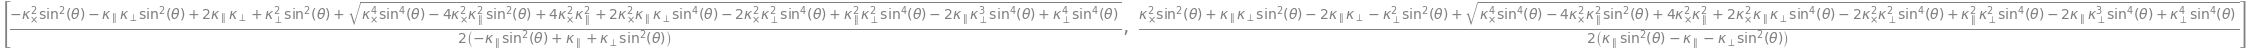

In [5]:
N2_sol = solve(Eq(dielectric_det_theta.subs(k, k_0 * N), 0), (N**2)); N2_sol

In [6]:
def N2_sol_theta(theta_value):
    N2_sol_theta_ = [sol.subs(theta, theta_value).simplify() for sol in N2_sol]
    return list(fuquad.simplify_quadratic_sols(N2_sol_theta_[0], N2_sol_theta_[1]))

In [7]:
N2_sol_theta(0)

In [8]:
N2_sol_theta(pi/2)

In [9]:
def kappa2omega(expr, plasma_type='electron'):
    from sympy import expand, cancel, factor
    if plasma_type == 'electron':
        expr = expr.subs(kappa_perp, 1 - omega_pe**2 / (omega**2 - omega_ce**2))
        expr = expr.subs(kappa_times, (omega_ce / omega) * (omega_pe**2 / (omega**2 - omega_ce**2)))
        expr = expr.subs(kappa_para, 1 - omega_pe**2 / omega**2 ) 
        expr = expr.simplify()
    elif plasma_type == 'electron+ion':
        raise NotImplementedError("Not yet prepared for neutral plasma with electron and pure ion species.")
    else:
        raise ValueError("Unprepared plasma type")
    return expr

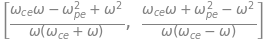

In [10]:
N2_sol_omega = list(map(kappa2omega, N2_sol_theta(0))); N2_sol_omega

In [11]:
import fusystem.algebra.parameter as fupm

N2_sol_omega_uni = [sol.subs(omega_ce, fupm.omega_ce(B=5)[0]).subs(omega_pe, fupm.omega_pe(n_0=1e20, B=5)[0]) for sol in N2_sol_omega]
[fualguti.find_singularities(sol, omega) for sol in N2_sol_omega_uni]

## Draw Dispersion Relation


$N^2(\omega)$

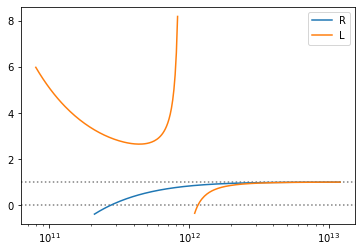

In [12]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.axhline(y=0, color='grey', linestyle=':')
ax.axhline(y=1, color='grey', linestyle=':')

draw_discontinuable_expr(
    N2_sol_omega_uni, omega, 
    varlim=(0.8e11, 1.2e13), exprlim=(-0.4, 10.0), num=250,
    var_sample_scale='log', fig=fig, ax=ax, labels=['R', 'L'])


ax.set_xscale('log')
ax.tick_params(axis='x', which='minor', bottom=True, labelbottom=True)
ax.legend()


<string>:2: RuntimeWarning: invalid value encountered in sqrt
<string>:2: RuntimeWarning: invalid value encountered in sqrt


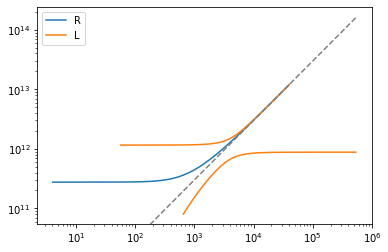

In [13]:
import matplotlib.pyplot as plt
from scipy.constants import c
from sympy import sqrt, Abs
import numpy as np
fig, ax = plt.subplots()

k_sol_omega_uni = list(map(lambda expr: omega / c * sqrt(expr), N2_sol_omega_uni)); k_sol_omega_uni
# k_sol_omega_uni = list(map(lambda expr: omega / c * sqrt(Abs(expr)), N2_sol_omega_uni)); k_sol_omega_uni

varlim = (0.8e11, 1.2e13)
exprlim= (0, 1e7)
draw_discontinuable_expr(
    k_sol_omega_uni, omega, 
    varlim=varlim, exprlim=exprlim, num=int(1e5), var_is_yaxis=True,
    var_sample_scale='log', fig=fig, ax=ax, labels=['R', 'L'])

def add_line_with_slope(ax, k:float, num=50, **kwargs):
    lower, upper = ax.get_xbound()
    x_range_ = np.linspace(lower, upper, num=num)
    y_range_ = k * x_range_ 
    ax.plot(x_range_, y_range_, **kwargs)
add_line_with_slope(ax, c, num=500, color='grey', linestyle='--')

ax.set_xscale('log')
ax.set_yscale('log')
ax.tick_params(axis='x', which='minor', bottom=True, labelbottom=True)
ax.tick_params(axis='y', which='minor', left=True, labelleft=True)
ax.legend()